In [15]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from gmphd import mtt_phd
from utils import *

In [16]:
# Measurement parameters
dim = 2
dt = 1.0
num_steps = 20

birth_prob = 0.2
death_prob = 0.005

det_prob = 0.9
clutter_rate = 3

pos_bounds = (-30, 30)
vel_bounds = (-1, 1)

area = (-100, 100)

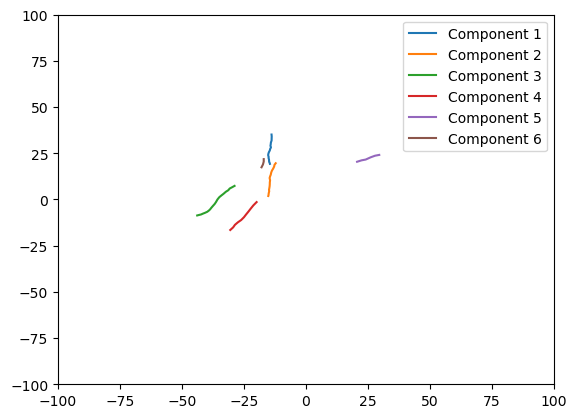

In [17]:
# generate ground truth data
F = create_state_matrix(dt, dim)
Q = np.identity(F.shape[0]) * 0.01

truths = simulate_motion(F, Q, num_steps=num_steps, birth_prob=birth_prob, death_prob=death_prob, pos_bounds=pos_bounds, vel_bounds=vel_bounds)
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
    plt.xlim(*area)
    plt.ylim(*area)
plt.legend()

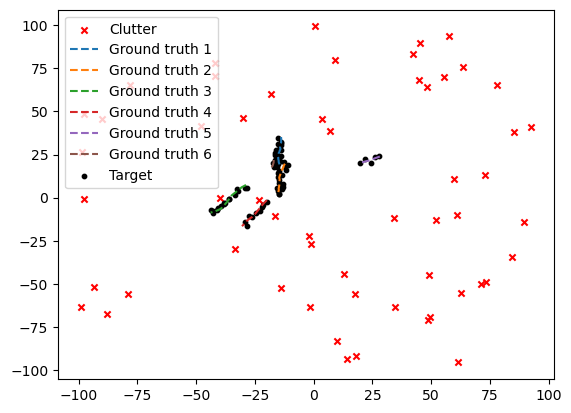

In [18]:
# generate measurements
H = create_measurement_matrix(dim)
R = np.identity(H.shape[0]) * 0.75

all_measurements = simulate_measurement(truths, H, R, num_steps=num_steps, det_prob=det_prob, clutter_rate=clutter_rate, area=area)

component_ids = sorted({i for measurements in all_measurements.values() for i, _ in measurements if i is not None})

for measurements in all_measurements.values():
    for i, measurement in measurements:
        if i is None:
            plt.scatter(measurement[0], measurement[1], c='red', marker='x', label='Clutter', s=20)
        else:
            plt.scatter(measurement[0], measurement[1], color='black', label=f'Target', s=10)
    
for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    # print(pos)
    plt.plot(*pos[:,:2].T, label=f'Ground truth {i + 1}', linestyle='dashed')

# ignore duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
order = np.argsort(list(unique.keys()))
plt.legend([list(unique.values())[i] for i in order], [list(unique.keys())[i] for i in order])

In [19]:
print("F")
print(F)
print("Q")
print(Q)
print("H")
print(H)
print("R")
print(R)

F
[[1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
Q
[[0.01 0.   0.   0.  ]
 [0.   0.01 0.   0.  ]
 [0.   0.   0.01 0.  ]
 [0.   0.   0.   0.01]]
H
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]]
R
[[0.75 0.  ]
 [0.   0.75]]


In [20]:
# get initial truths
init_truths = []
for states in truths.values():
    if states[0] is not None:
        init_truths.append(states[0])
    
init_truths = np.array(init_truths)

num_components = len(init_truths)

# assume each component has the same weight
component_weight = 1.0

# the variance of pos and vel
pos_var = 10
vel_var = 5

# each component assumed to start at a random (x, y) ~ U([-100, 100] x [-100, 100])
start_bounds = (-50, 50)

w = [component_weight] * num_components
m = init_truths.copy()
m = np.array(m)
P = np.array([np.diag([pos_var, pos_var, vel_var, vel_var])**2 for _ in range(num_components)])

In [21]:
print("Initial weights:")
print(w)
print("Initial means:")
print(m)
print("Initial covariances:")
print(P)

Initial weights:
[1.0, 1.0, 1.0]
Initial means:
[[-14.54168064  19.27075348  -0.09999182   0.71718532]
 [-12.21198662  19.61166893  -0.39579442  -0.85556721]
 [-28.80302758   7.35388223  -0.84598309  -0.75383271]]
Initial covariances:
[[[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]

 [[100   0   0   0]
  [  0 100   0   0]
  [  0   0  25   0]
  [  0   0   0  25]]]


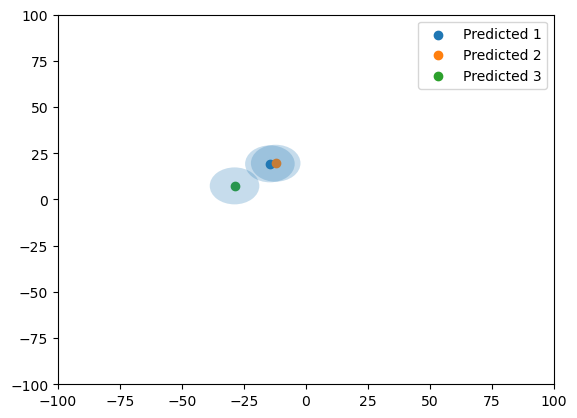

In [22]:
fig, ax = plt.subplots()
for i in range(len(w)):
    pos = m[i][:2]
    cov = P[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Predicted {i + 1}')
    ax.add_patch(unc)
    ax.set_xlim(*area)
    ax.set_ylim(*area)
plt.legend()

# Spawning

In [23]:
# initialize the filter
filter = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=det_prob,
    clutter_intensity=clutter_rate/np.prod(np.diff(np.vstack([area, area]))),
    merging_threshold = 5.0, # 5
    truncation_threshold = 1e-8, # make sure squared
    threshold_weight= 0.4, # 0.60799
    new_birth_weight=0.25, # 0.25,
    spawning = True
)

history = filter.full_PHD_filter_run()

Prev pos: [-25.82589107   8.00450367], New pos: [-26.47487115   7.49428149]
Prev pos: [-10.88522494  18.66500496], New pos: [-11.16865508  18.53890533]
Prev pos: [-14.30740195  21.12242431], New pos: [-14.5935303   21.01400491]
Prev pos: [-24.56167006   9.48938331], New pos: [-25.17232789   9.01934461]
Prev pos: [-13.8616296   21.25399291], New pos: [-14.45579298  21.47532361]
Prev pos: [-11.21394471  18.84640637], New pos: [-11.49718818  18.72218139]
Prev pos: [-16.79376612  17.785291  ], New pos: [-18.43253467  17.55143785]
Prev pos: [-26.75562174   7.20725202], New pos: [-25.61439713   6.31101417]
Prev pos: [-29.96128004   4.02978415], New pos: [-31.88274038   0.1137431 ]
Prev pos: [-26.38748759  10.23997089], New pos: [-27.03242103   9.73283723]
Prev pos: [-12.11269249  22.04131375], New pos: [-12.39267473  21.93245981]
Prev pos: [-3.89629585 29.30123364], New pos: [-1.5057164  32.44400313]
Prev pos: [-0.64255295 32.55102919], New pos: [ 2.48667103 36.50387873]
Prev pos: [-7.650597

KeyboardInterrupt: 

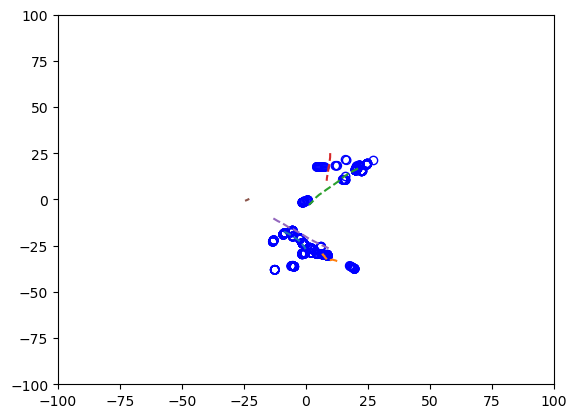

In [ ]:
pos = np.array([s[:2] for s in history[-1]])
plt.scatter(*pos[:,:2].T, facecolors='none', edgecolors='blue')
plt.xlim(*area)
plt.ylim(*area)

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, linestyle='dashed')

# No Spawning

In [ ]:
# initialize the filter
filter_nospawn = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=det_prob,
    clutter_intensity=clutter_rate/np.prod(np.diff(np.vstack([area, area]))),
    merging_threshold = 5.0, # 5
    truncation_threshold = 1e-8, # make sure squared
    threshold_weight= 0.607, # 0.60799
    new_birth_weight=0.25, # 0.25,
    spawning = False
)

history = filter_nospawn.full_PHD_filter_run()

Prev pos: [20.51740313 18.10676738], New pos: [19.65736683 17.56222547]
Prev pos: [  4.03627004 -28.44905403], New pos: [  4.30344982 -28.78564849]
Prev pos: [-12.61353733 -38.01294533], New pos: [-12.13519173 -38.37935745]
Prev pos: [20.54251322 17.7805684 ], New pos: [19.68247183 17.23602601]
Prev pos: [  3.25142122 -27.66720786], New pos: [  3.55097066 -28.00837311]
Prev pos: [ -8.60292487 -18.31084046], New pos: [ -7.8611139  -19.21488471]
Prev pos: [-12.71872232 -38.17887221], New pos: [-12.24037673 -38.54528432]
Prev pos: [  8.28259089 -29.99112222], New pos: [  9.05699412 -30.43281942]
Prev pos: [19.57353197 16.28701163], New pos: [18.71357203 15.7424771 ]
Prev pos: [ -5.63270616 -18.28446952], New pos: [ -9.45136561 -14.77095988]
Prev pos: [-10.14445903 -17.19558192], New pos: [ -9.87727925 -17.53217637]
Prev pos: [34.56372247  5.73395839], New pos: [33.70368618  5.18941648]
Prev pos: [38.65347834 25.48286934], New pos: [54.96636563 33.33777675]
Prev pos: [24.98993681 36.974539

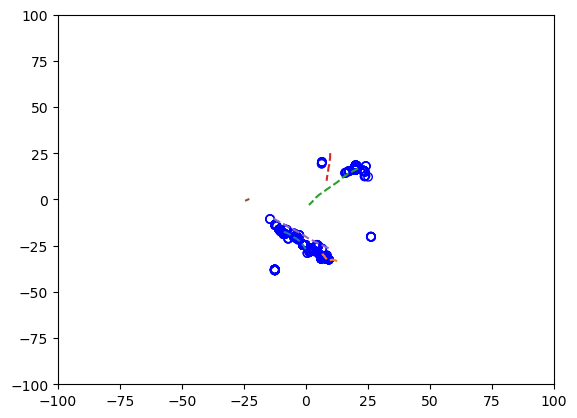

In [ ]:
pos = np.array([s[:2] for s in history[-1]])
plt.scatter(*pos[:,:2].T, facecolors='none', edgecolors='blue')
plt.xlim(*area)
plt.ylim(*area)

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])

for i, state in truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, linestyle='dashed')